In [1]:
import sys
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from ddpg_agent import Agent

%matplotlib inline

In [2]:
class Params():
    pass

In [3]:
scores = pickle.load(open('./scores.p', 'rb'))
params = pickle.load(open('./params.p', 'rb'))


In [4]:
scores_mean = [scores[0]]
scores_05 = [scores[0]]
scores_95 = [scores[0]]
scores_std = [0]
scores_above_threshold = [int((scores[0] >= 0.5))]
for i in range(1, len(scores)):
    seg = scores[max(0, i-100):i]
    scores_mean.append(np.mean(seg))
    scores_05.append(np.percentile(seg, 5))
    scores_95.append(np.percentile(seg, 95))
    scores_std.append(np.std(seg))
    scores_above_threshold.append(np.sum([1 for x in seg if x >=0.5]))
scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)


In [5]:
x = np.arange(len(scores))

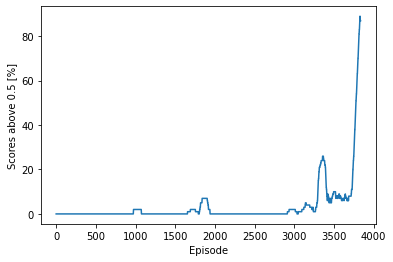

In [6]:
f = plt.figure()
plt.plot(x, scores_above_threshold)
plt.xlabel('Episode')
plt.ylabel('Scores above 0.5 [%]')
plt.show()

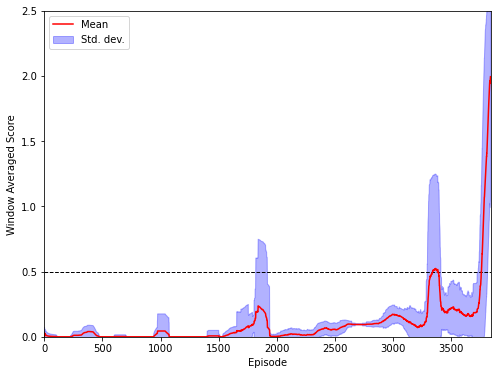

Avg. score 0.5 threshold achieved after 3440 episodes.


In [7]:
def plot_mean_chart(x, scores_mean, scores_std, scores_05, scores_95, filename = None, xticks=None, xmin = 0):
    f = plt.figure(figsize=(8, 6))
    plt.plot(x, scores_mean, '-', color = 'r')
    plt.fill_between(x, scores_mean - scores_std, scores_mean + scores_std, alpha = 0.30, color = 'b')
    #plt.fill_between(x, scores_05, scores_95, alpha = 0.15, color = 'g')
    plt.xlabel('Episode')
    plt.ylabel('Window Averaged Score')
    plt.hlines(0.5, 0, len(scores), colors='black', linestyles='--', linewidth=1)
    plt.xlim(xmin, len(scores))
    plt.ylim(0, 2.5)
    plt.legend(['Mean', 'Std. dev.'], loc='upper left')
    if xticks is not None:
        plt.xticks(xticks)

    if filename is not None:
        plt.savefig(filename)
    plt.show()

plot_mean_chart(x, scores_mean, scores_std, scores_05, scores_95, './img/averaged_scores_train.jpg')
print ('Avg. score 0.5 threshold achieved after {} episodes.'.format(101+np.argmax(scores_mean >=0.5)))


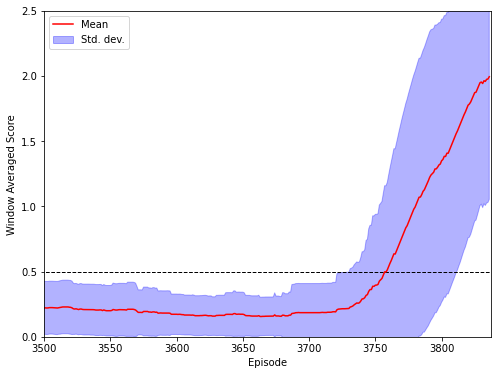

Avg. score 0.5 threshold achieved after 3759 episodes.


In [8]:
plot_mean_chart(x, scores_mean, scores_std, scores_05, scores_95, './img/averaged_scores_train3500.jpg', xmin=3500)
print ('Avg. score 0.5 threshold achieved after {} episodes.'.format(3500 + np.argmax(scores_mean[3500:] >=0.5)))

# Let's see how the trained agent works

In [9]:
env = UnityEnvironment(file_name='./Tennis_Windows_x86_64/Tennis.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [10]:
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=True)[brain_name]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]


In [11]:
agent = Agent(params)
agent.actor_local.load_state_dict(torch.load('./models/checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('./models/checkpoint_critic.pth'))

In [12]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations    
score = 0
step = 0
scores = np.zeros(params.NUM_AGENTS)                   # initialize the score (for each agent)
while True:
    actions_ag1 = agent.act(states[0], add_noise=False)
    actions_ag2 = agent.act(states[1], add_noise=False)
    env_info = env.step(np.concatenate((actions_ag1, actions_ag2), axis=0))[brain_name]
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
    
print('Score (max over agents): {}'.format(np.max(scores)))

Score (max over agents): 2.600000038743019


In [13]:
env.close()